In [16]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import shapely.geometry as geo
from tqdm.notebook import tqdm
import glob
%matplotlib inline

## Settings

In [6]:
experiments_path = "/home/shoerl/temp/melun_drt/output"
figures_path = "/home/shoerl/temp/melun_drt/figures"

## Demand

In [7]:
df_demand = pd.read_csv(
    "{}/exclusivity_share0.0_exclusivefalse_seed0/ITERS/it.0/0.drt_legs_drt.csv".format(experiments_path), 
    sep = ";")

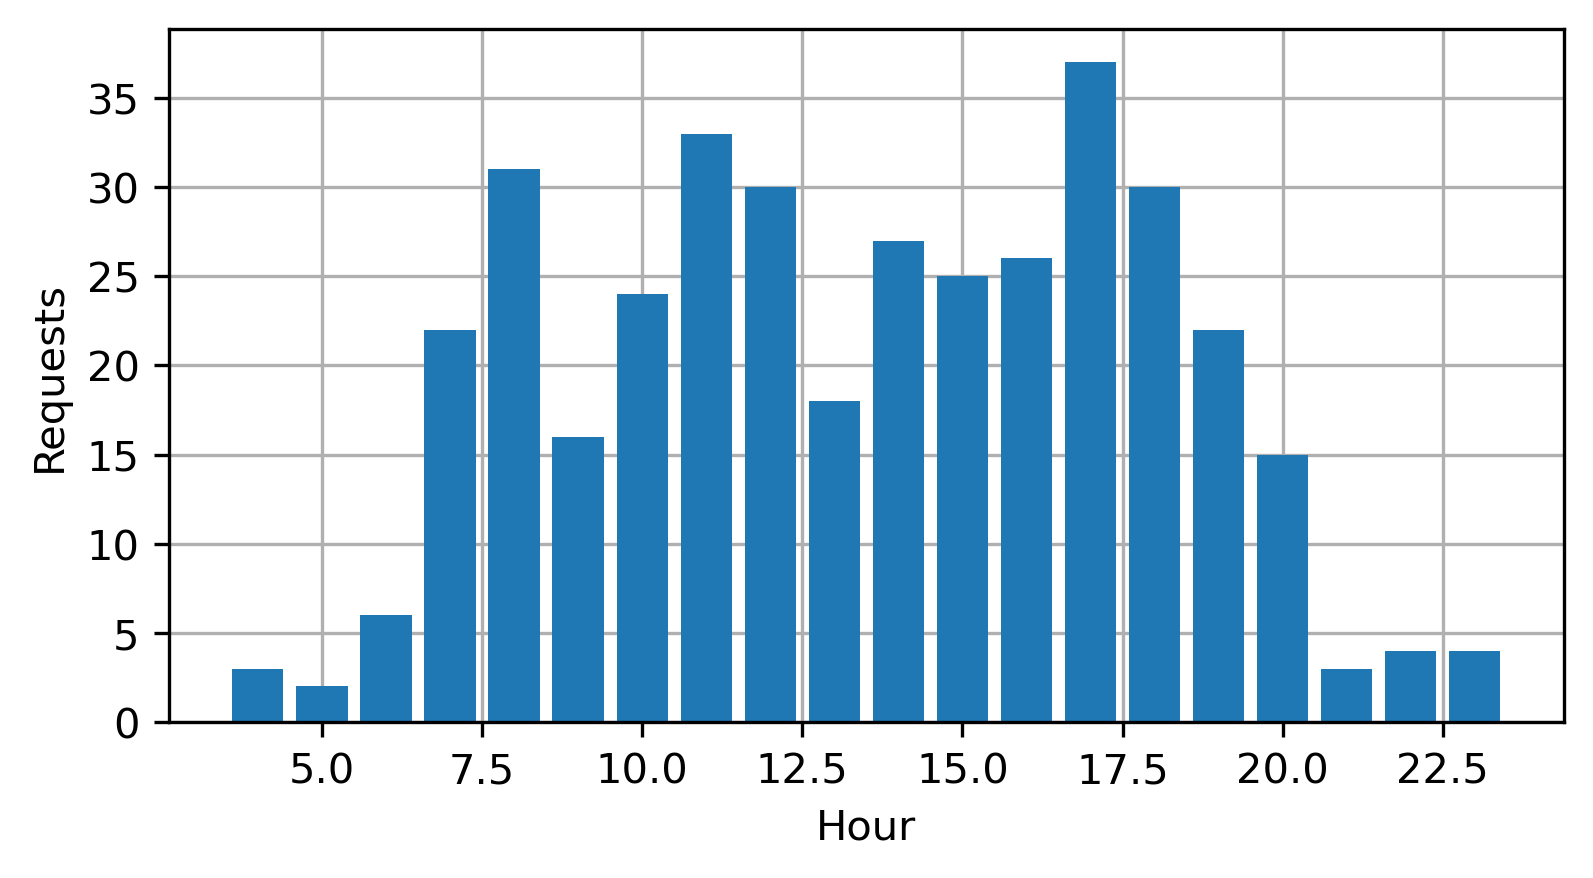

In [10]:
plt.figure(dpi = 300, figsize = (6, 3))
df_demand["hour"] = df_demand["departureTime"] // 3600

hours = np.arange(4, 24)
counts = [np.count_nonzero(df_demand["hour"] == h) for h in hours]

plt.grid(zorder = 0)
plt.bar(hours, counts, zorder = 2)
plt.xlabel("Hour")
plt.ylabel("Requests")
plt.savefig("{}/requests_by_hour.pdf".format(figures_path))

In [12]:
# Write Geopackage for visualization in QGIS
df_geometry = gpd.GeoDataFrame(pd.DataFrame({ "geometry": [
    geo.LineString([o, d]) for o, d in zip(
        gpd.points_from_xy(df_demand["fromX"], df_demand["fromY"]),
        gpd.points_from_xy(df_demand["toX"], df_demand["toY"])
    )
]}), crs = "EPSG:2154")

df_geometry.to_file("{}/trips.gpkg".format(experiments_path))

## Prebooking

In [24]:
df = []

for path in tqdm(glob.glob("{}/*".format(experiments_path))):    
    name = path.split("/")[-1]
    
    if not name.startswith("main_"):
        continue
    
    segments = name.split("_")

    segment = segments[1]
    assert segment.startswith("share")
    share = float(segment.replace("share", ""))
    
    segment = segments[2]
    assert segment.startswith("slack")
    horizon = float(segment.replace("slack", ""))
    
    segment = segments[3]
    assert segment.startswith("seed")
    seed = float(segment.replace("seed", ""))
    
    segment = segments[4]
    assert segment.startswith("wait")
    wait = "pre" if segment.replace("wait", "") == "true" else "post"
    
    try:
        df_legs = pd.read_csv("{}/output_drt_legs_drt.csv".format(path), sep = ";")
        df_rejections = pd.read_csv("{}/output_drt_rejections_drt.csv".format(path), sep = ";")
        df_delay = pd.read_csv("{}/output_drt_detours_drt.csv".format(path), sep = ";")
        df_vehicles = pd.read_csv("{}/output_vehicleDistanceStats_drt.csv".format(path), sep = ";")
        df_prebooking = pd.read_csv("{}/ITERS/it.0/0.prebooking_drt.csv".format(path), sep = ",")
        
        # Immediate retry requests are rejected by default in our simulation setup
        df_rejections = df_rejections.drop_duplicates("personId", keep = "first")
        
        absolute_detour = df_delay["time"] - df_delay["unsharedTime"]
        relative_detour = absolute_detour / df_delay["unsharedTime"]
        
        
        served_requests = len(df_legs)
        rejected_requests = len(df_rejections)
        
        prebooked_served = len(df_legs[df_legs["personId"].isin(df_prebooking["person_id"])])
        immediate_served = served_requests - prebooked_served
        
        prebooked_rejected = len(df_rejections[df_rejections["personId"].isin(df_prebooking["person_id"])])
        immediate_rejected = rejected_requests - prebooked_rejected
        
        df.append({
            "share": share, "horizon": horizon, "seed": seed, "wait": wait,
            "served": served_requests,
            "rejected": rejected_requests,
            "max_wait_time": df_legs["waitTime"].max(),
            "mean_wait_time": df_legs["waitTime"].mean(),
            "q90_wait_time": df_legs["waitTime"].quantile(0.9),
            "absolute_detour": absolute_detour.mean(),
            "relative_detour": relative_detour.mean(),
            "driven_distance": df_vehicles["drivenDistance_m"].sum(),
            "empty_distance_share": df_vehicles["emptyDistance_m"].sum() / df_vehicles["drivenDistance_m"].sum(),
            "passenger_distance": df_legs["travelDistance_m"].sum(),
            "prebooked_served": prebooked_served, "prebooked_rejected": prebooked_rejected,
            "immediate_served": immediate_served, "immediate_rejected": immediate_rejected
        })
    except FileNotFoundError:
        pass
    
df = pd.DataFrame.from_records(df)

df["rejection_rate"] = df["rejected"] / (df["served"] + df["rejected"])
df["prebooked_rejection_rate"] = df["prebooked_rejected"] / (df["prebooked_served"] + df["prebooked_rejected"])
df["immediate_rejection_rate"] = df["immediate_rejected"] / (df["immediate_served"] + df["immediate_rejected"])

  0%|          | 0/771 [00:00<?, ?it/s]

In [25]:
df_fill = [df]

for share in df["share"].unique():
    if share > 0.0:
        df_copy = df[df["horizon"] == 0.0].copy()
        df_copy["share"] = share
        df_fill.append(df_copy)
        
df = pd.concat(df_fill)

In [26]:
horizon_labels = ["10 Minutes", "1 Hour", "4 Hours", "Morning"]
horizons = [600.0, 3600.0, 4.0 * 3600.0, 48.0 * 3600.0]

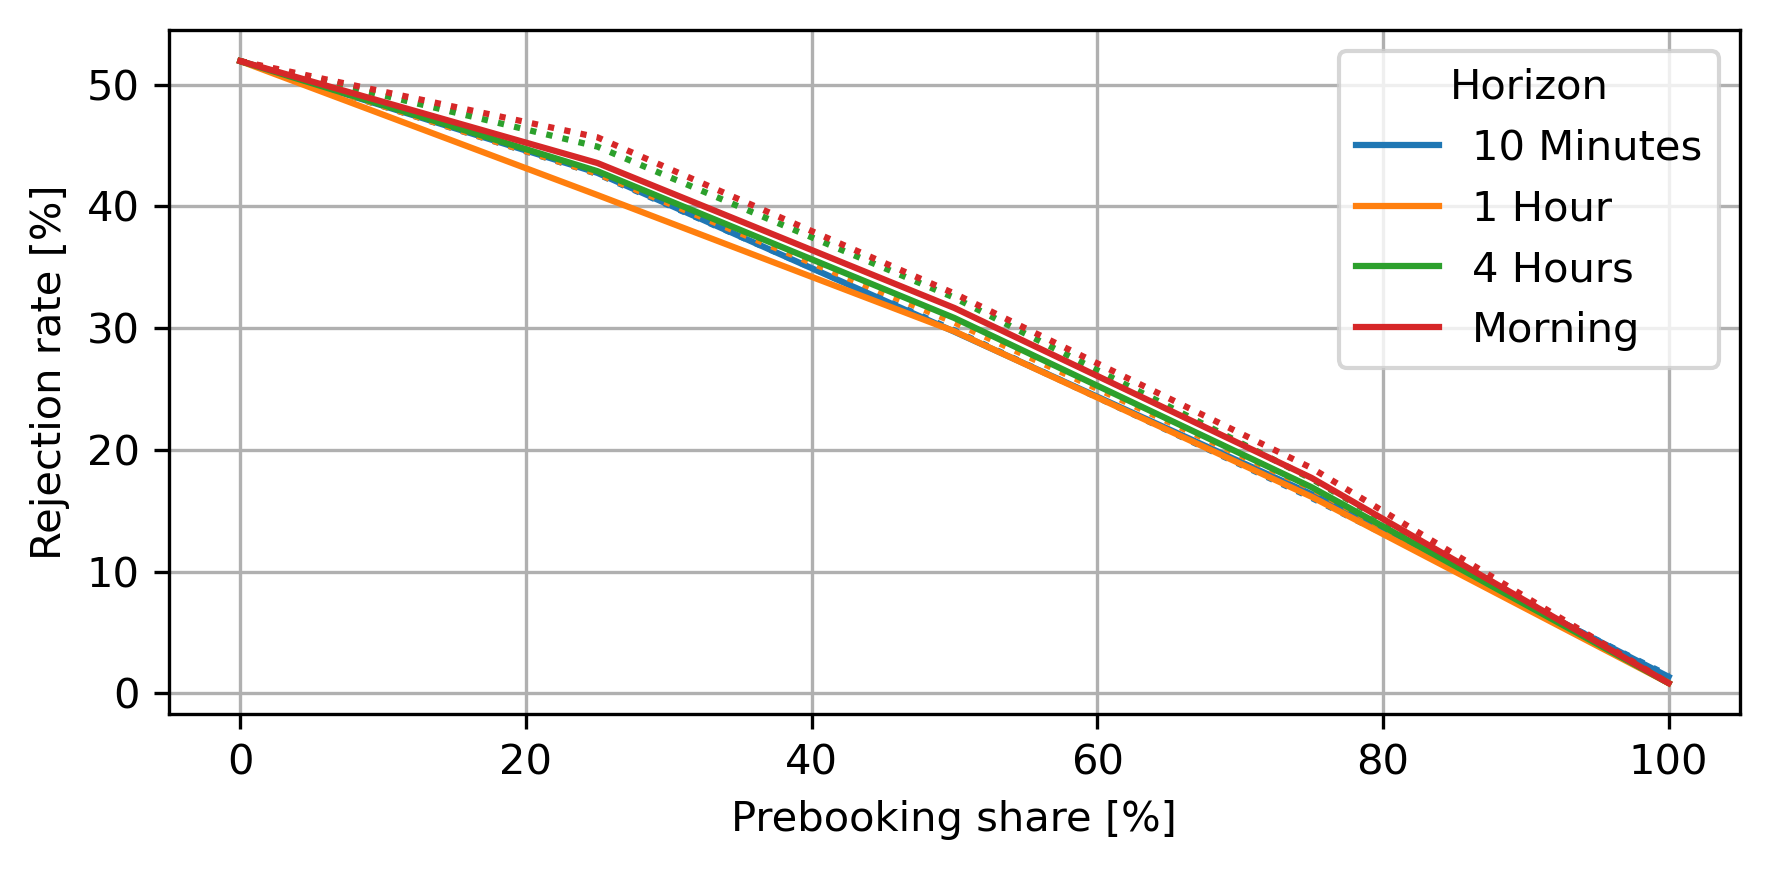

In [28]:
plt.figure(dpi = 300, figsize = (6, 3))

for horizon_index, horizon in enumerate(horizons):
    plt.plot([None], [None], color = "C{}".format(horizon_index), label = horizon_labels[horizon_index])
    
    for wait in ("pre", "post"):
        linestyle = dict(post = "-", pre = ":")[wait]
        
        df_plot = df[(df["horizon"] == horizon) & (df["wait"] == wait)].copy()
        df_plot["share"] *= 1e2
        df_plot["rejection_rate"] *= 1e2
        
        df_plot = df_plot.groupby(by = "share")["rejection_rate"].aggregate((
            "mean", "min", "max", "std")).reset_index()
        
        plt.plot(df_plot["share"], df_plot["mean"], 
            color = "C{}".format(horizon_index),
            linestyle = linestyle)
        
plt.xlabel("Prebooking share [%]")
plt.ylabel("Rejection rate [%]")
plt.legend(loc = "best", title = "Horizon")
        
plt.grid()
plt.tight_layout()
plt.savefig("{}/melun_rejection_rate.pdf".format(figures_path))

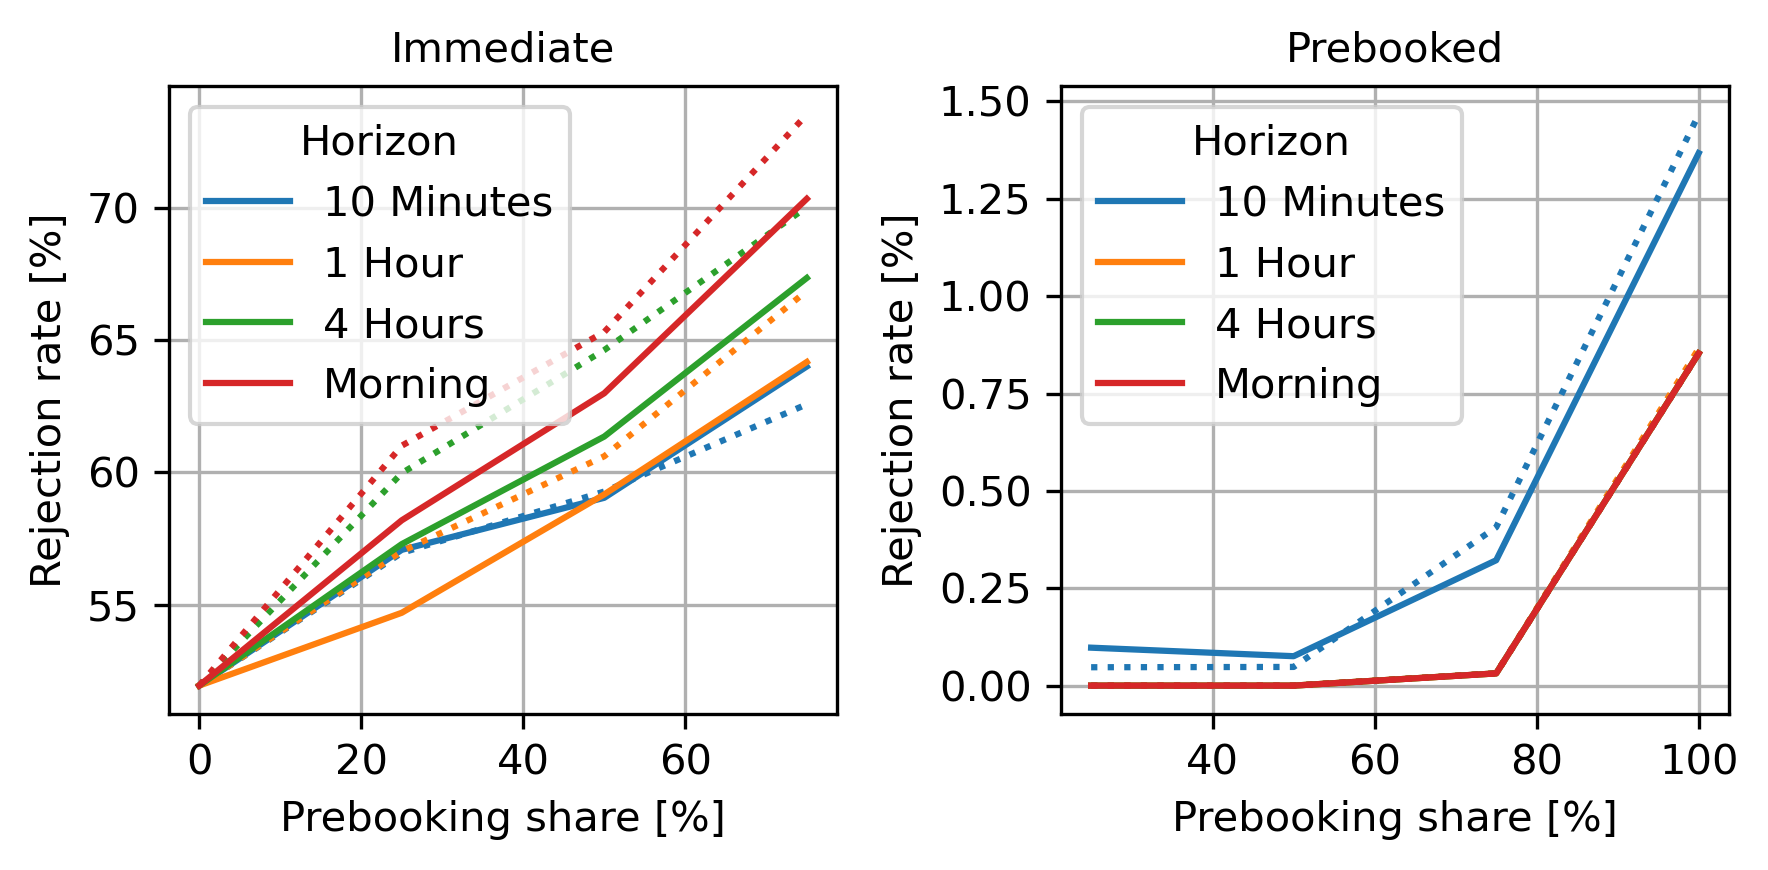

In [29]:
plt.figure(dpi = 300, figsize = (6, 3))

prefix_labels = ["Immediate", "Prebooked"]

for prefix_index, prefix in enumerate(("immediate", "prebooked")):
    plt.subplot(1, 2, prefix_index + 1)
    
    for horizon_index, horizon in enumerate(horizons):
        plt.plot([None], [None], color = "C{}".format(horizon_index), label = horizon_labels[horizon_index])

        for wait in ("pre", "post"):
            linestyle = dict(post = "-", pre = ":")[wait]

            df_plot = df[(df["horizon"] == horizon) & (df["wait"] == wait)].copy()
            df_plot["share"] *= 1e2
            df_plot["{}_rejection_rate".format(prefix)] *= 1e2

            df_plot = df_plot.groupby(by = "share")["{}_rejection_rate".format(prefix)].aggregate((
                "mean", "min", "max", "std")).reset_index()

            plt.plot(df_plot["share"], df_plot["mean"], 
                color = "C{}".format(horizon_index),
                linestyle = linestyle)

    plt.xlabel("Prebooking share [%]")
    plt.ylabel("Rejection rate [%]")
    plt.legend(loc = "best", title = "Horizon")
    plt.title(prefix_labels[prefix_index], fontsize = 10)
    plt.grid()
    
plt.tight_layout()
plt.savefig("{}/melun_rejection_rate_by_type.pdf".format(figures_path))

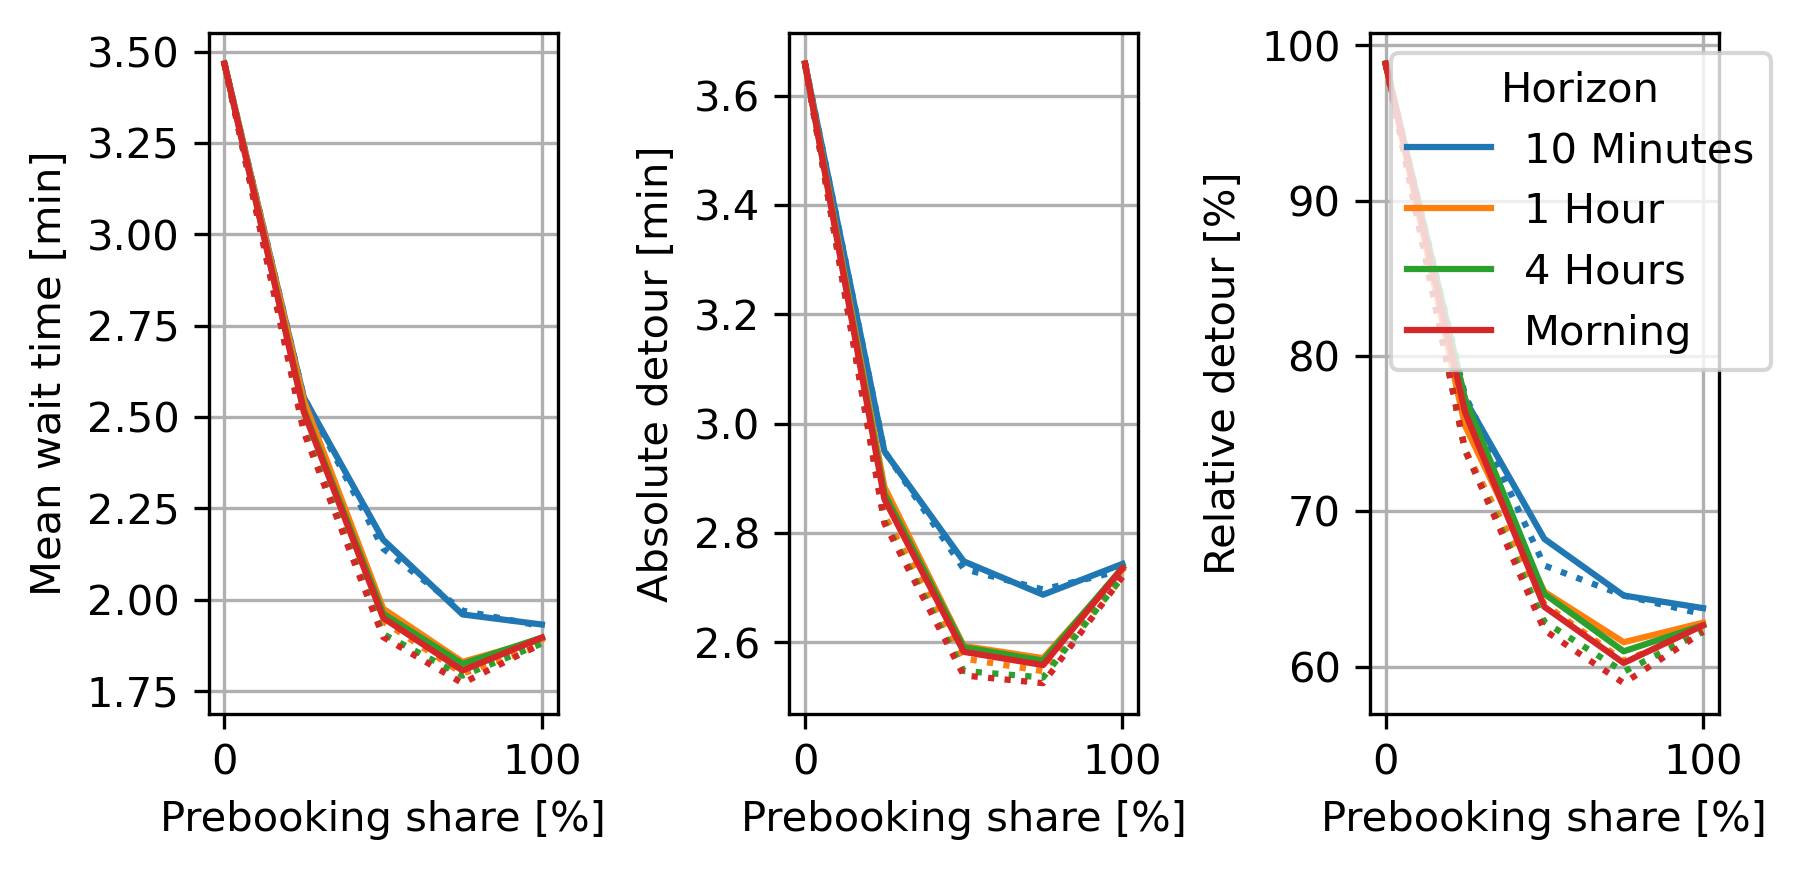

In [30]:
plt.figure(dpi = 300, figsize = (6, 3))

plt.subplot(1, 3, 1)
for horizon_index, horizon in enumerate(horizons):
    plt.plot([None], [None], color = "C{}".format(horizon_index), label = horizon_labels[horizon_index])
    
    for wait in ("pre", "post"):
        linestyle = dict(post = "-", pre = ":")[wait]
        
        df_plot = df[(df["horizon"] == horizon) & (df["wait"] == wait)].copy()
        df_plot["share"] *= 1e2
        df_plot["mean_wait_time"] /= 60
        
        df_plot = df_plot.groupby(by = "share")["mean_wait_time"].aggregate((
            "mean", "min", "max", "std")).reset_index()
        
        plt.plot(df_plot["share"], df_plot["mean"], 
            color = "C{}".format(horizon_index),
            linestyle = linestyle)
        
        #std_factor = 1.0
        #plt.fill_between(df_plot["share"], 
        #    df_plot["mean"] - df_plot["std"] * std_factor, df_plot["mean"] + df_plot["std"] * std_factor, 
        #    color = "C{}".format(horizon_index), alpha = 0.1, linewidth = 0)

plt.xlabel("Prebooking share [%]")
plt.ylabel("Mean wait time [min]")
#plt.legend(loc = "best", title = "Horizon")
plt.grid()

plt.subplot(1, 3, 2)
for horizon_index, horizon in enumerate(horizons):
    plt.plot([None], [None], color = "C{}".format(horizon_index), label = horizon_labels[horizon_index])
    
    for wait in ("pre", "post"):
        linestyle = dict(post = "-", pre = ":")[wait]
        
        df_plot = df[(df["horizon"] == horizon) & (df["wait"] == wait)].copy()
        df_plot["share"] *= 1e2
        df_plot["absolute_detour"] /= 60
        
        df_plot = df_plot.groupby(by = "share")["absolute_detour"].aggregate((
            "mean", "min", "max", "std")).reset_index()
        
        plt.plot(df_plot["share"], df_plot["mean"], 
            color = "C{}".format(horizon_index),
            linestyle = linestyle)
        
        #std_factor = 1.0
        #plt.fill_between(df_plot["share"], 
        #    df_plot["mean"] - df_plot["std"] * std_factor, df_plot["mean"] + df_plot["std"] * std_factor, 
        #    color = "C{}".format(horizon_index), alpha = 0.1, linewidth = 0)

plt.xlabel("Prebooking share [%]")
plt.ylabel("Absolute detour [min]")
#plt.legend(loc = "best", title = "Horizon")
        
plt.grid()

plt.subplot(1, 3, 3)
for horizon_index, horizon in enumerate(horizons):
    plt.plot([None], [None], color = "C{}".format(horizon_index), label = horizon_labels[horizon_index])
    
    for wait in ("pre", "post"):
        linestyle = dict(post = "-", pre = ":")[wait]
        
        df_plot = df[(df["horizon"] == horizon) & (df["wait"] == wait)].copy()
        df_plot["share"] *= 1e2
        df_plot["relative_detour"] *= 1e2
        
        df_plot = df_plot.groupby(by = "share")["relative_detour"].aggregate((
            "mean", "min", "max", "std")).reset_index()
        
        plt.plot(df_plot["share"], df_plot["mean"], 
            color = "C{}".format(horizon_index),
            linestyle = linestyle)
        
plt.xlabel("Prebooking share [%]")
plt.ylabel("Relative detour [%]")
plt.legend(loc = "best", title = "Horizon")
        
plt.grid()

plt.tight_layout()
plt.savefig("{}/melun_operational.pdf".format(figures_path))

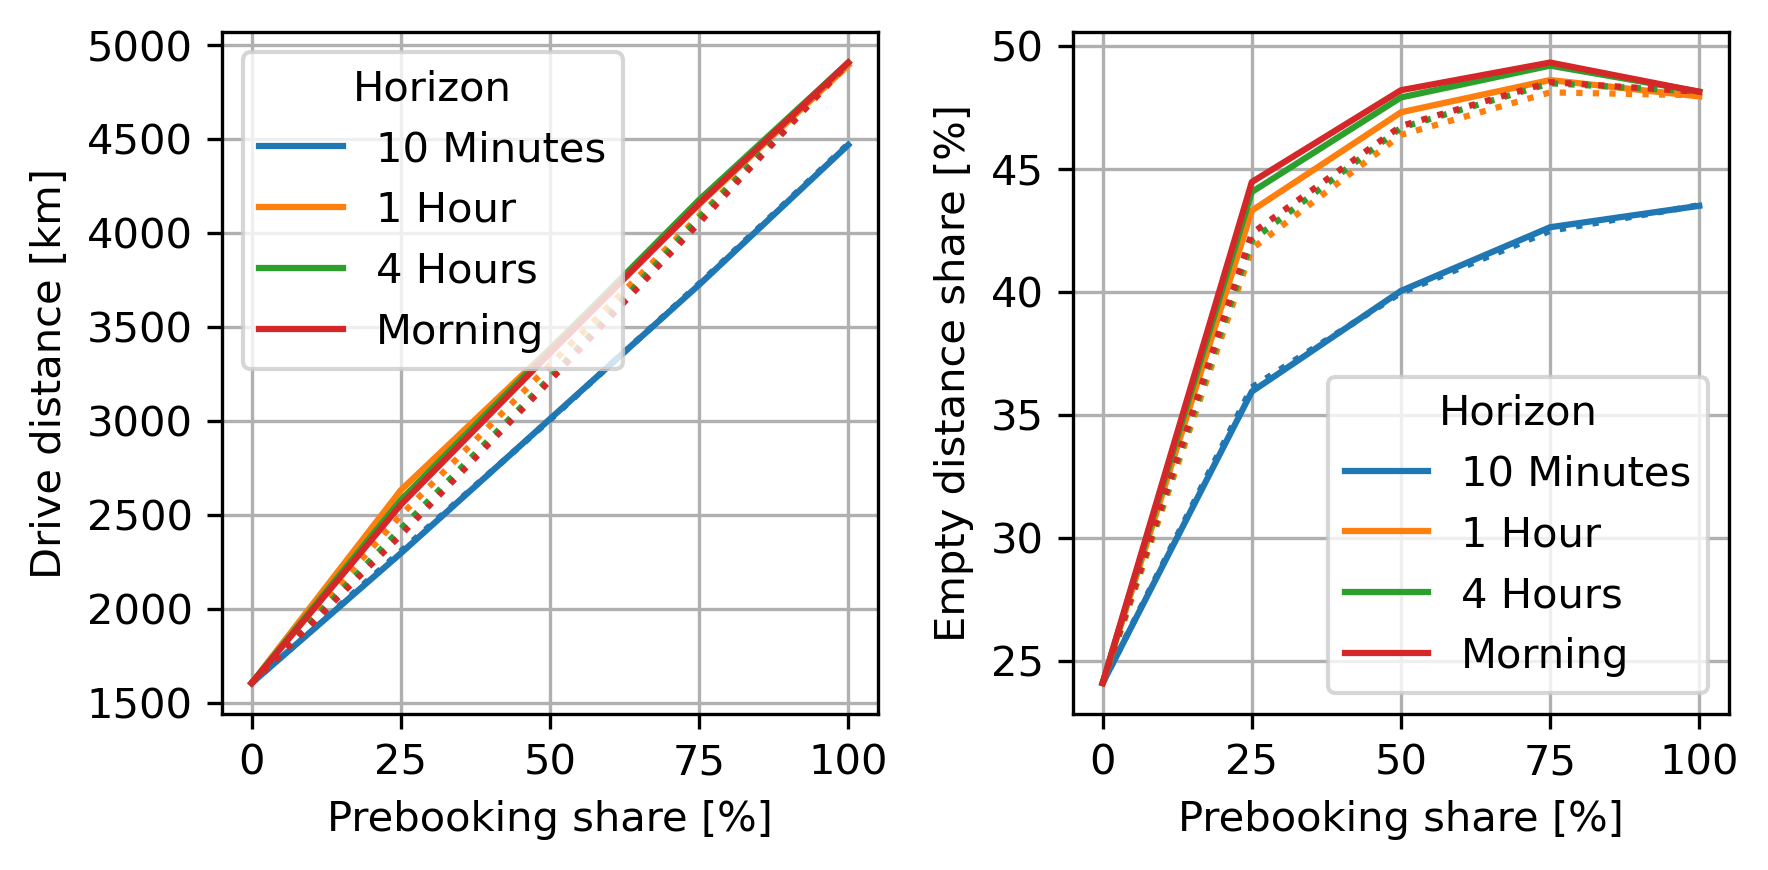

In [31]:
plt.figure(dpi = 300, figsize = (6, 3))

plt.subplot(1, 2, 1)
for horizon_index, horizon in enumerate(horizons):
    plt.plot([None], [None], color = "C{}".format(horizon_index), label = horizon_labels[horizon_index])
    
    for wait in ("pre", "post"):
        linestyle = dict(post = "-", pre = ":")[wait]
        
        df_plot = df[(df["horizon"] == horizon) & (df["wait"] == wait)].copy()
        df_plot["share"] *= 1e2
        df_plot["driven_distance"] *= 1e-3
        
        df_plot = df_plot.groupby(by = "share")["driven_distance"].aggregate((
            "mean", "min", "max", "std")).reset_index()
        
        plt.plot(df_plot["share"], df_plot["mean"], 
            color = "C{}".format(horizon_index),
            linestyle = linestyle)
        
        #std_factor = 1.0
        #plt.fill_between(df_plot["share"], 
        #    df_plot["mean"] - df_plot["std"] * std_factor, df_plot["mean"] + df_plot["std"] * std_factor, 
        #    color = "C{}".format(horizon_index), alpha = 0.1, linewidth = 0)

plt.xlabel("Prebooking share [%]")
plt.ylabel("Drive distance [km]")
plt.legend(loc = "best", title = "Horizon")
        
plt.grid()

plt.subplot(1, 2, 2)
for horizon_index, horizon in enumerate(horizons):
    plt.plot([None], [None], color = "C{}".format(horizon_index), label = horizon_labels[horizon_index])
    
    for wait in ("pre", "post"):
        linestyle = dict(post = "-", pre = ":")[wait]
        
        df_plot = df[(df["horizon"] == horizon) & (df["wait"] == wait)].copy()
        df_plot["share"] *= 1e2
        df_plot["empty_distance_share"] *= 1e2
        
        df_plot = df_plot.groupby(by = "share")["empty_distance_share"].aggregate((
            "mean", "min", "max", "std")).reset_index()
        
        plt.plot(df_plot["share"], df_plot["mean"], 
            color = "C{}".format(horizon_index),
            linestyle = linestyle)
        
plt.xlabel("Prebooking share [%]")
plt.ylabel("Empty distance share [%]")
plt.legend(loc = "best", title = "Horizon")
        
plt.grid()

plt.tight_layout()
plt.savefig("{}/melun_distances.pdf".format(figures_path))

## Vehicle range constraint

In [37]:
df = []

for path in tqdm(glob.glob("{}/*".format(experiments_path))):    
    name = path.split("/")[-1]
    
    if not name.startswith("range_"):
        continue
    
    segments = name.split("_")

    segment = segments[1]
    assert segment.startswith("share")
    share = float(segment.replace("share", ""))
    
    segment = segments[2]
    assert segment.startswith("constraint")
    constraint = float(segment.replace("constraint", ""))
    
    segment = segments[3]
    assert segment.startswith("seed")
    seed = float(segment.replace("seed", ""))
    
    try:
        df_legs = pd.read_csv("{}/output_drt_legs_drt.csv".format(path), sep = ";")
        df_rejections = pd.read_csv("{}/output_drt_rejections_drt.csv".format(path), sep = ";")
        df_delay = pd.read_csv("{}/output_drt_detours_drt.csv".format(path), sep = ";")
        df_vehicles = pd.read_csv("{}/output_vehicleDistanceStats_drt.csv".format(path), sep = ";")
        df_prebooking = pd.read_csv("{}/ITERS/it.0/0.prebooking_drt.csv".format(path), sep = ",")
        
        # Immediate retry requests are rejected by default in our simulation setup
        df_rejections = df_rejections.drop_duplicates("personId", keep = "first")
        
        absolute_detour = df_delay["time"] - df_delay["unsharedTime"]
        relative_detour = absolute_detour / df_delay["unsharedTime"]
        
        
        served_requests = len(df_legs)
        rejected_requests = len(df_rejections)
        
        prebooked_served = len(df_legs[df_legs["personId"].isin(df_prebooking["person_id"])])
        immediate_served = served_requests - prebooked_served
        
        prebooked_rejected = len(df_rejections[df_rejections["personId"].isin(df_prebooking["person_id"])])
        immediate_rejected = rejected_requests - prebooked_rejected
        
        distances = df_vehicles["drivenDistance_m"].values
        
        df.append({
            "share": share, "constraint": constraint, "seed": seed,
            "served": served_requests,
            "rejected": rejected_requests,
            "max_wait_time": df_legs["waitTime"].max(),
            "mean_wait_time": df_legs["waitTime"].mean(),
            "q90_wait_time": df_legs["waitTime"].quantile(0.9),
            "absolute_detour": absolute_detour.mean(),
            "relative_detour": relative_detour.mean(),
            "driven_distance": df_vehicles["drivenDistance_m"].sum(),
            "empty_distance_share": df_vehicles["emptyDistance_m"].sum() / df_vehicles["drivenDistance_m"].sum(),
            "passenger_distance": df_legs["travelDistance_m"].sum(),
            "prebooked_served": prebooked_served, "prebooked_rejected": prebooked_rejected,
            "immediate_served": immediate_served, "immediate_rejected": immediate_rejected,
            "min_distance": np.min(distances),
            "max_distance": np.max(distances),
            "mean_distance": np.mean(distances)
        })
    except FileNotFoundError:
        pass
    
df = pd.DataFrame.from_records(df)

df["rejection_rate"] = df["rejected"] / (df["served"] + df["rejected"])
df["prebooked_rejection_rate"] = df["prebooked_rejected"] / (df["prebooked_served"] + df["prebooked_rejected"])
df["immediate_rejection_rate"] = df["immediate_rejected"] / (df["immediate_served"] + df["immediate_rejected"])

  0%|          | 0/771 [00:00<?, ?it/s]

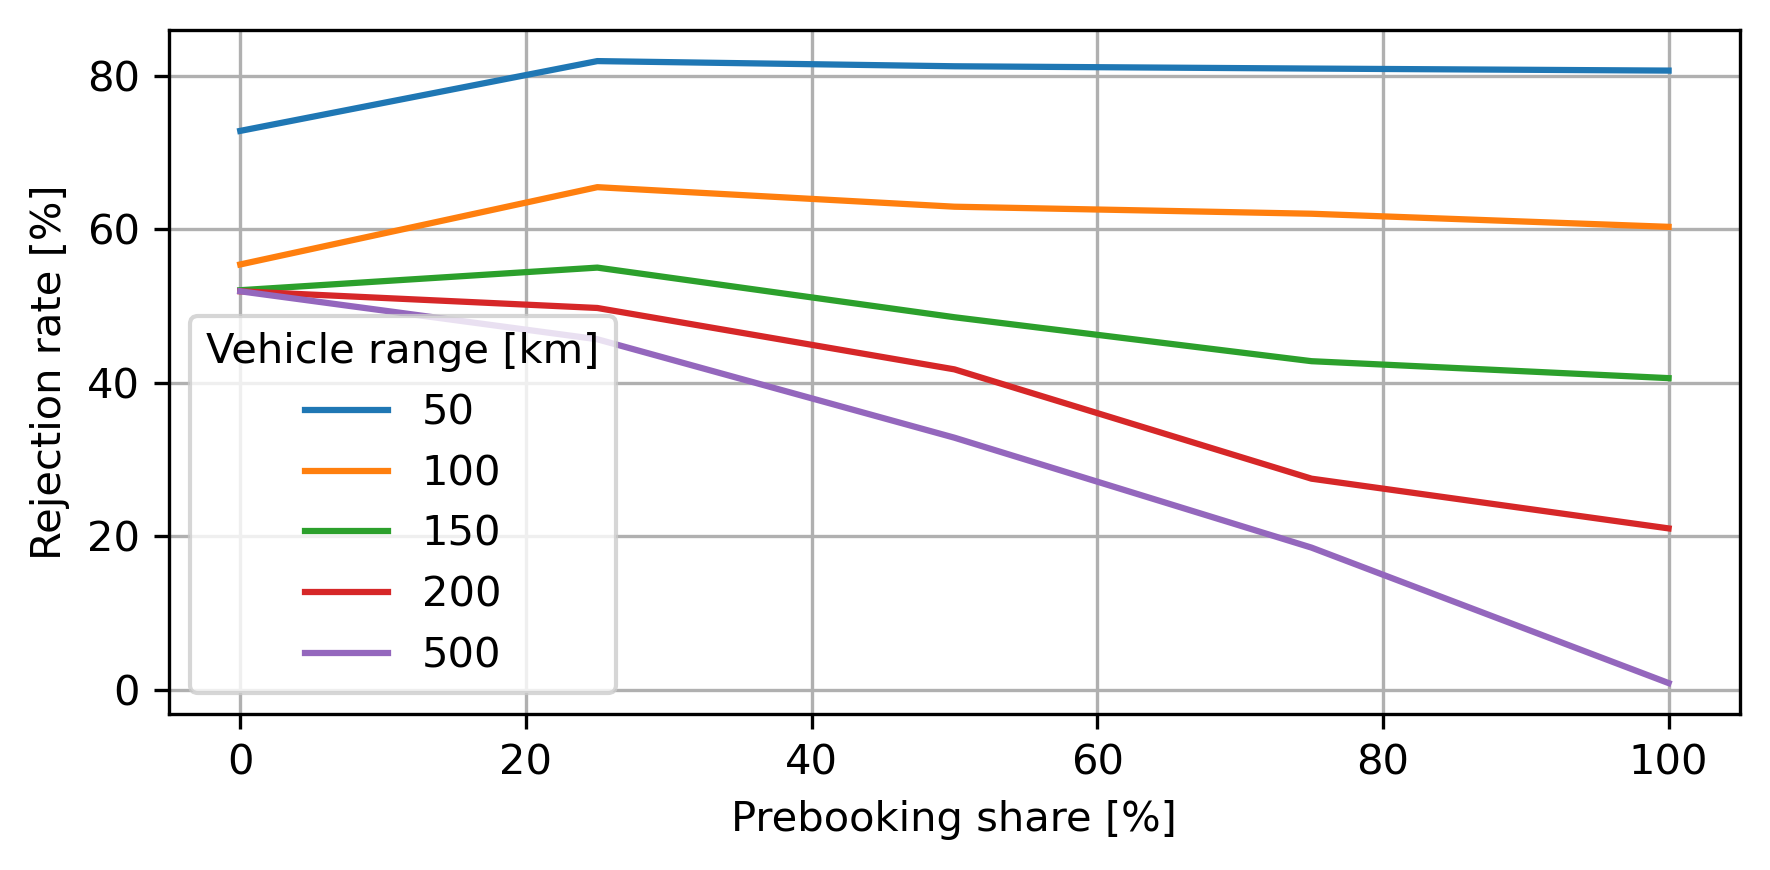

In [38]:
plt.figure(dpi = 300, figsize = (6, 3))

constraint_values = sorted(df["constraint"].unique())
constraint_labels = ["{:d}".format(int(c)) for c in constraint_values]

for constraint_index, contraint_value in enumerate(constraint_values):
    df_plot = df[(df["constraint"] == contraint_value)].copy()
    df_plot["share"] *= 1e2
    df_plot["rejection_rate"] *= 1e2

    df_plot = df_plot.groupby(by = "share")["rejection_rate"].aggregate((
        "mean", "min", "max", "std")).reset_index()

    plt.plot(df_plot["share"], df_plot["mean"], 
        color = "C{}".format(constraint_index), label = constraint_labels[constraint_index])

plt.xlabel("Prebooking share [%]")
plt.ylabel("Rejection rate [%]")
plt.legend(loc = "best", title = "Vehicle range [km]")
        
plt.grid()
plt.tight_layout()
plt.savefig("{}/melun_range_rejections.pdf".format(figures_path))

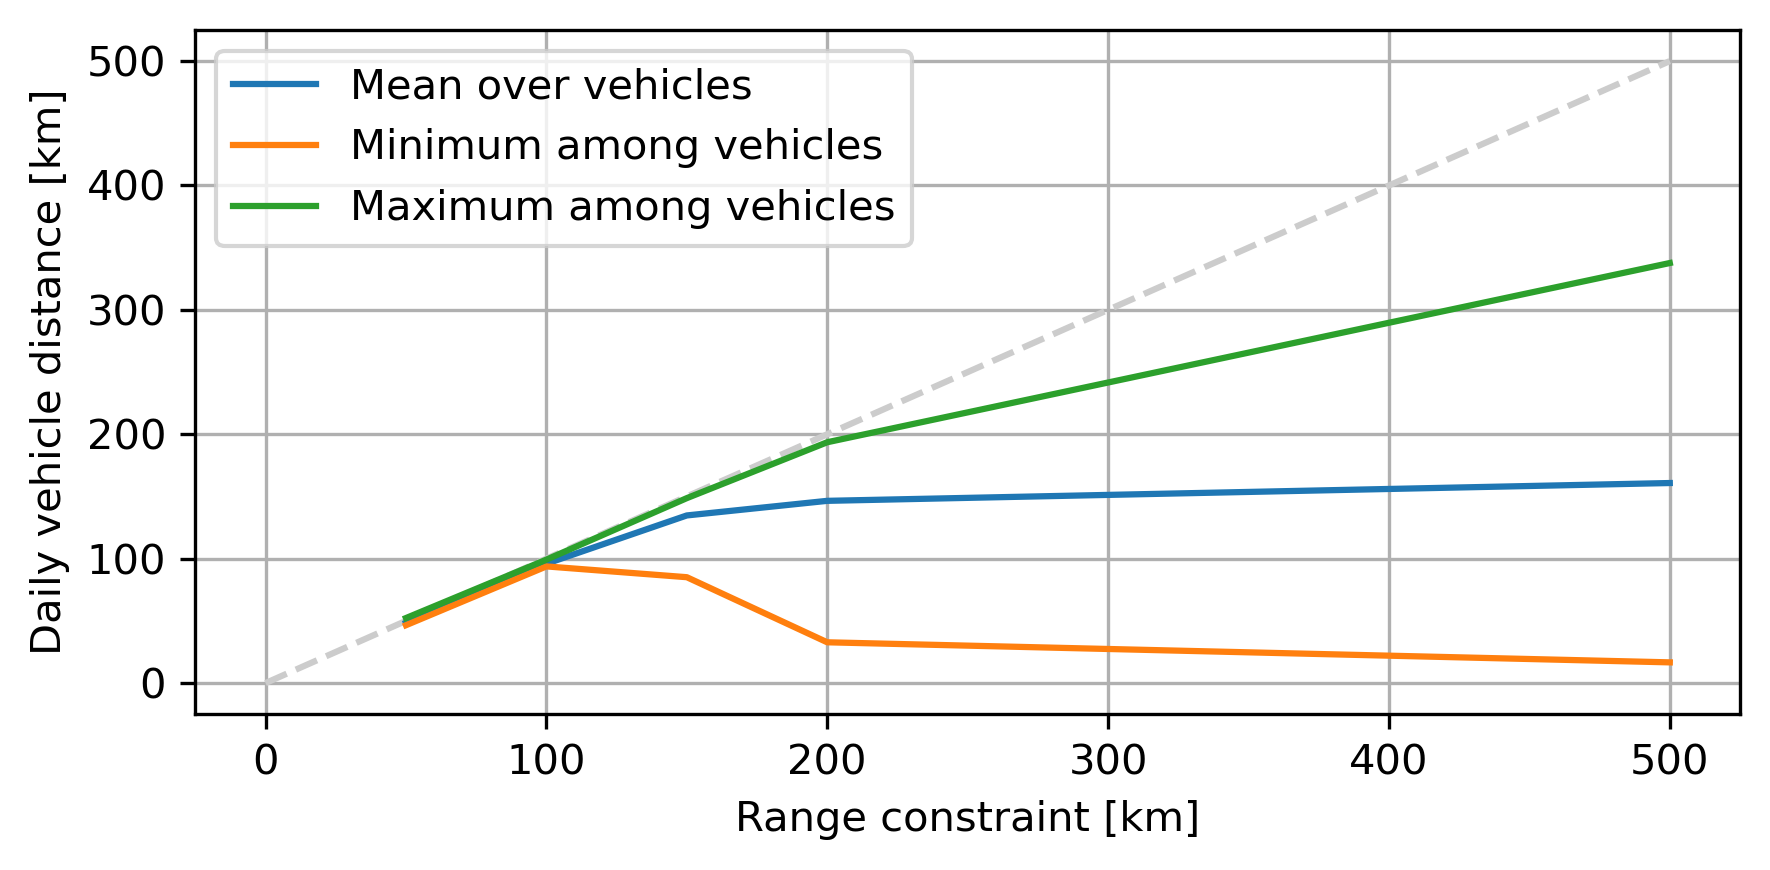

In [39]:
plt.figure(dpi = 300, figsize = (6, 3))

share = 0.5
df_plot = df[(df["share"] == share)].copy()
df_plot = df_plot.sort_values("constraint")

plt.plot([0, 500], [0, 500], "--", color = "#cccccc")

df_plot = df_plot.groupby("constraint")[["mean_distance", "min_distance", "max_distance"]].mean().reset_index()
plt.plot(df_plot["constraint"], df_plot["mean_distance"] * 1e-3, label = "Mean over vehicles")
plt.plot(df_plot["constraint"], df_plot["min_distance"] * 1e-3, label = "Minimum among vehicles")
plt.plot(df_plot["constraint"], df_plot["max_distance"] * 1e-3, label = "Maximum among vehicles")

plt.xlabel("Range constraint [km]")
plt.ylabel("Daily vehicle distance [km]")
plt.legend(loc = "best")
        
plt.grid()
plt.tight_layout()
plt.savefig("{}/melun_range_distances.pdf".format(figures_path))

## Exclusivity constraint

In [32]:
def count_overlap(df_legs):
    df_scope = df_legs[["personId", "prebooked", "pickupTime", "dropoffTime", "vehicleId"]].copy()

    overlap_prebooked = 0
    overlap_immediate = 0
    
    for k in range(len(df_scope)):
        row = df_scope.iloc[k]

        df_other = df_scope[row["vehicleId"] == df_scope["vehicleId"]].copy()
        has_overlap = False

        if len(df_other) > 0:
            # Pickup is covered by other leg
            f_pickup = (row["pickupTime"] > df_other["pickupTime"]) & (row["pickupTime"] < df_other["dropoffTime"])

            # Dropoff is covered by other leg
            f_dropoff = (row["dropoffTime"] > df_other["pickupTime"]) & (row["dropoffTime"] < df_other["dropoffTime"])

            # Covering other pickup
            f_cover_pickup = (df_other["pickupTime"] > row["pickupTime"]) & (df_other["pickupTime"] < row["dropoffTime"])

            # Covering other dropoff
            f_cover_dropoff = (df_other["dropoffTime"] > row["pickupTime"]) & (df_other["dropoffTime"] < row["dropoffTime"])

            has_overlap = np.any(f_pickup | f_dropoff | f_cover_pickup | f_cover_dropoff)

        if has_overlap:
            if row["prebooked"]:
                overlap_prebooked += 1
            else:
                overlap_immediate += 1
    
    return overlap_prebooked, overlap_immediate

In [33]:
df = []

for path in tqdm(glob.glob("{}/*".format(experiments_path))):    
    name = path.split("/")[-1]
    
    if not name.startswith("exclusivity_"):
        continue
    
    segments = name.split("_")

    segment = segments[1]
    assert segment.startswith("share")
    share = float(segment.replace("share", ""))
    
    segment = segments[2]
    assert segment.startswith("exclusive")
    exclusive = segment.replace("exclusive", "") == "true"
    
    segment = segments[3]
    assert segment.startswith("seed")
    seed = float(segment.replace("seed", ""))
    
    try:
        df_legs = pd.read_csv("{}/output_drt_legs_drt.csv".format(path), sep = ";")
        df_rejections = pd.read_csv("{}/output_drt_rejections_drt.csv".format(path), sep = ";")
        df_delay = pd.read_csv("{}/output_drt_detours_drt.csv".format(path), sep = ";")
        df_vehicles = pd.read_csv("{}/output_vehicleDistanceStats_drt.csv".format(path), sep = ";")
        df_prebooking = pd.read_csv("{}/ITERS/it.0/0.prebooking_drt.csv".format(path), sep = ",")
        
        # Immediate retry requests are rejected by default in our simulation setup
        df_rejections = df_rejections.drop_duplicates("personId", keep = "first")
        
        absolute_detour = df_delay["time"] - df_delay["unsharedTime"]
        relative_detour = absolute_detour / df_delay["unsharedTime"]
        
        
        served_requests = len(df_legs)
        rejected_requests = len(df_rejections)
        
        prebooked_served = len(df_legs[df_legs["personId"].isin(df_prebooking["person_id"])])
        immediate_served = served_requests - prebooked_served
        
        prebooked_rejected = len(df_rejections[df_rejections["personId"].isin(df_prebooking["person_id"])])
        immediate_rejected = rejected_requests - prebooked_rejected
        
        distances = df_vehicles["drivenDistance_m"].values
        
        df_legs["pickupTime"] = df_legs["departureTime"] + df_legs["waitTime"]
        df_legs["dropoffTime"] = df_legs["arrivalTime"]
        df_legs["prebooked"] = df_legs["personId"].isin(df_prebooking["person_id"])
        
        overlap_prebooked, overlap_immediate = count_overlap(df_legs)
        
        df.append({
            "share": share, "exclusive": exclusive, "seed": seed,
            "served": served_requests,
            "rejected": rejected_requests,
            "max_wait_time": df_legs["waitTime"].max(),
            "mean_wait_time": df_legs["waitTime"].mean(),
            "q90_wait_time": df_legs["waitTime"].quantile(0.9),
            "absolute_detour": absolute_detour.mean(),
            "relative_detour": relative_detour.mean(),
            "driven_distance": df_vehicles["drivenDistance_m"].sum(),
            "empty_distance_share": df_vehicles["emptyDistance_m"].sum() / df_vehicles["drivenDistance_m"].sum(),
            "passenger_distance": df_legs["travelDistance_m"].sum(),
            "prebooked_served": prebooked_served, "prebooked_rejected": prebooked_rejected,
            "immediate_served": immediate_served, "immediate_rejected": immediate_rejected,
            "min_distance": np.min(distances),
            "max_distance": np.max(distances),
            "mean_distance": np.mean(distances),
            "overlap_prebooked": overlap_prebooked,
            "overlap_immediate": overlap_immediate
        })
    except FileNotFoundError:
        pass
    
df = pd.DataFrame.from_records(df)

df["rejection_rate"] = df["rejected"] / (df["served"] + df["rejected"])
df["prebooked_rejection_rate"] = df["prebooked_rejected"] / (df["prebooked_served"] + df["prebooked_rejected"])
df["immediate_rejection_rate"] = df["immediate_rejected"] / (df["immediate_served"] + df["immediate_rejected"])

  0%|          | 0/771 [00:00<?, ?it/s]

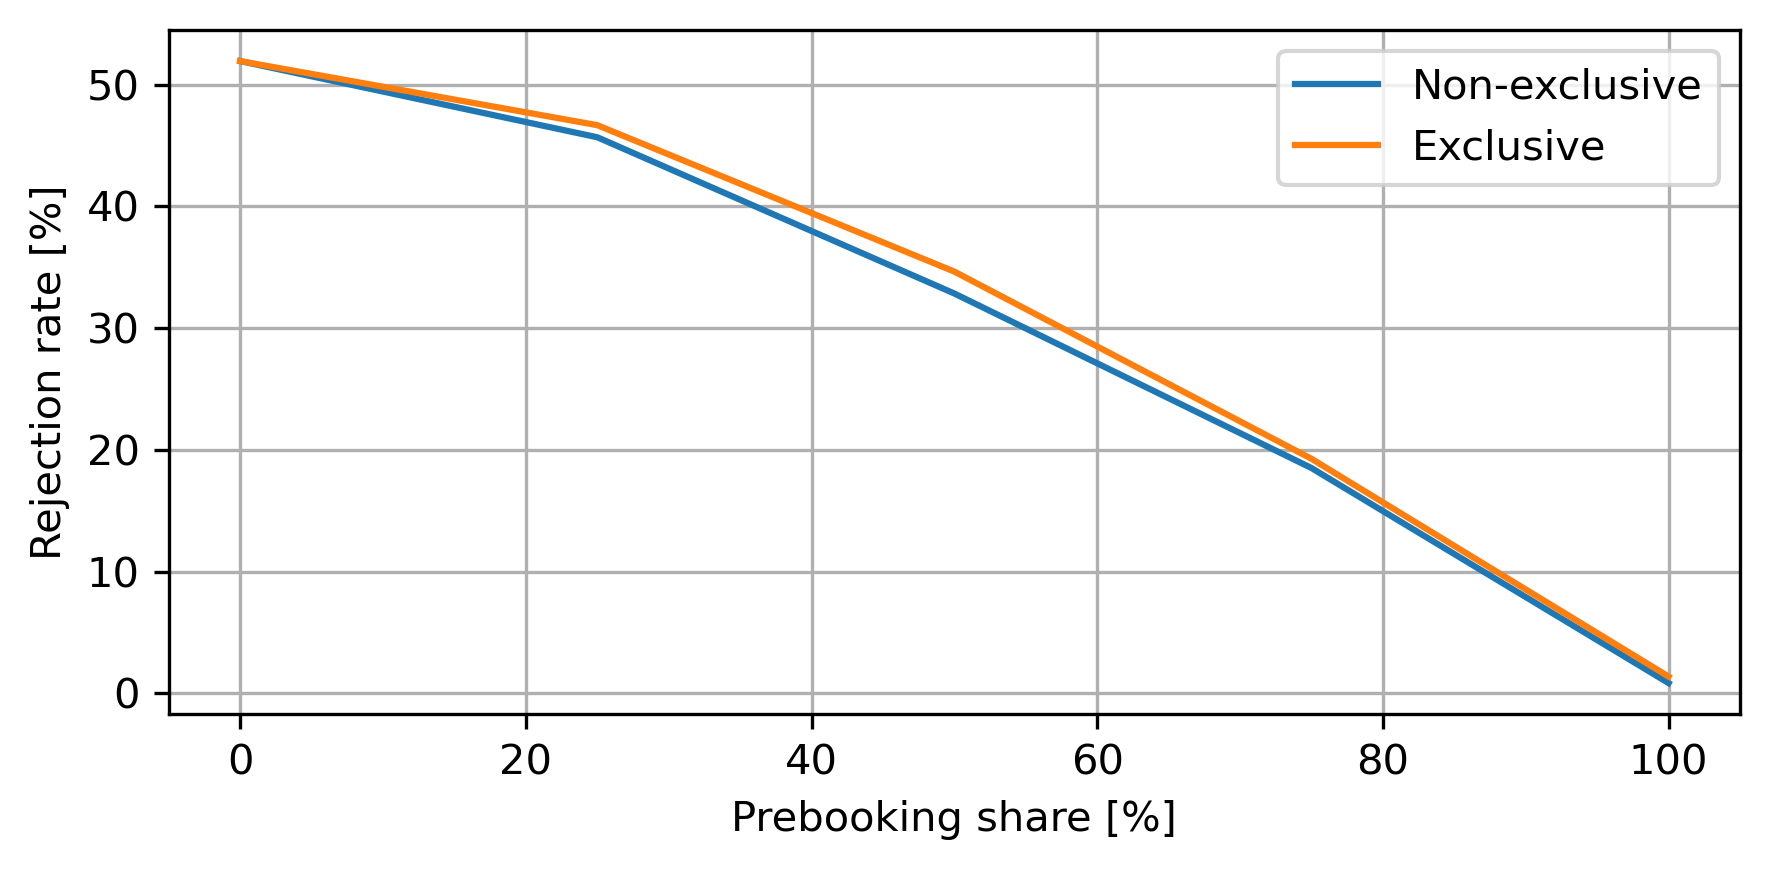

In [34]:
plt.figure(dpi = 300, figsize = (6, 3))

for exclusive in (False, True):
    df_plot = df[(df["exclusive"] == exclusive)].copy()
    df_plot["share"] *= 1e2
    df_plot["rejection_rate"] *= 1e2

    df_plot = df_plot.groupby(by = "share")["rejection_rate"].aggregate((
        "mean", "min", "max", "std")).reset_index()

    plt.plot(df_plot["share"], df_plot["mean"], 
        label = "Exclusive" if exclusive else "Non-exclusive")

plt.xlabel("Prebooking share [%]")
plt.ylabel("Rejection rate [%]")
plt.legend(loc = "best")
        
plt.grid()
plt.tight_layout()
plt.savefig("{}/melun_exclusivity_rejections.pdf".format(figures_path))

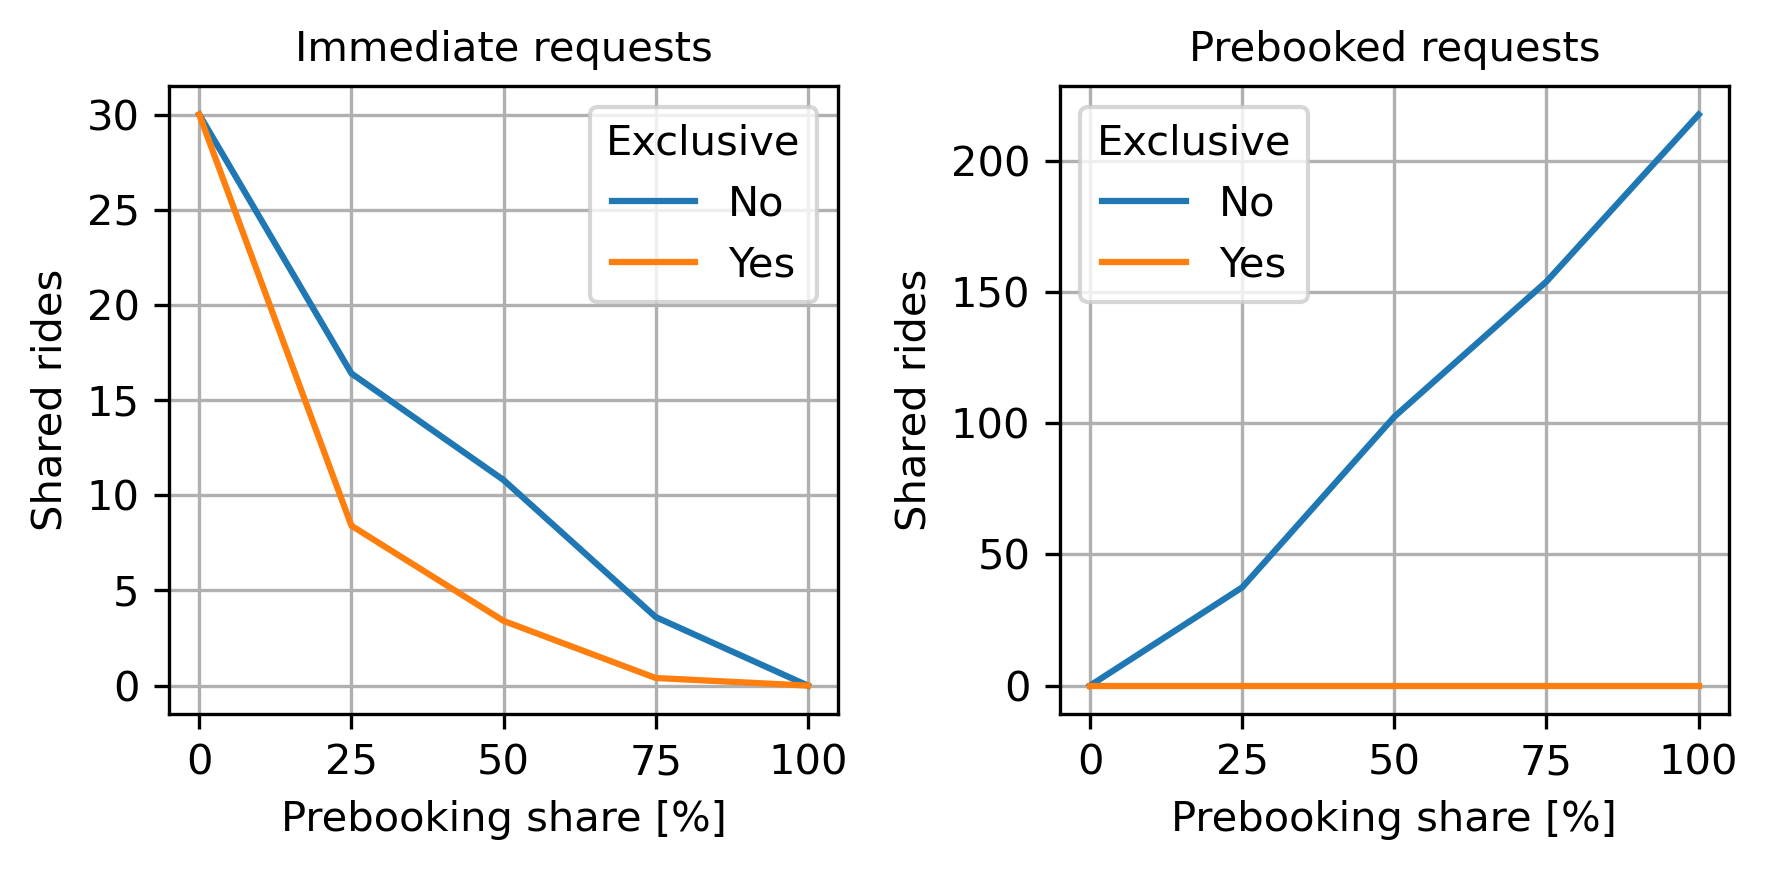

In [35]:
plt.figure(dpi = 300, figsize = (6, 3))

labels = { "immediate": "Immediate requests", "prebooked": "Prebooked requests"}

for subject_index, subject in enumerate(("immediate", "prebooked")):
    plt.subplot(1, 2, subject_index + 1)
    
    for exclusive in (False, True):
        df_plot = df[(df["exclusive"] == exclusive)].copy()
        df_plot["share"] *= 1e2
        
        slot = "overlap_{}".format(subject)

        df_plot = df_plot.groupby(by = "share")[slot].aggregate((
            "mean", "min", "max", "std")).reset_index()

        plt.plot(df_plot["share"], df_plot["mean"], 
            label = "Yes" if exclusive else "No")

    plt.xlabel("Prebooking share [%]")
    plt.ylabel("Shared rides")
    plt.legend(loc = "best", title = "Exclusive")
    plt.title(labels[subject], fontsize = 10)

    plt.grid()
    
plt.tight_layout()
plt.savefig("{}/melun_exclusivity_sharing.pdf".format(figures_path))